# DSCI 100-Group Project : Predicting Type 1 Diabetes
Bhavya Mohan, Jason Jonathan, Sherin Xierenayi, Neha Menon

Introduction: 

Diabetes is a common disease that is characterised by immune cells' targeting of beta-cells that produce insulin. Approximately 1.4 million people around the world receive the diabetic diagnosisEach year. Type 1 diabetes is a genetic disorder, however type 2 diabetes is brought on by environmental factors. As a result, it's critical to identify type 2 diabetes at an early stage in order to stop the condition from progressing. To help people assess their risk for developing diabetes, we intend to categorise the prevalence of diabetes based on characteristics that are simple to measure. We'll make use of a dataset created by Rajput et al., who gathered information on physical characteristics and diabetes, and the possible predictors include AGE, Urea, Cr, HbA1c, Chol, TG, HDL, LDL, VLDL. We want to answer the question that can we use the non-invasive diabetic measurements to predict whether an unknown case falls into categories of diabetic, non-diabetic or pre-diabetic diagnosis?

We choose Hb1Ac vs BMI as our predictors, as literature concluded that they are diabetic indicators and are strongly correlated with diagnosis. A hemoglobin A1C (HbA1C)1 test is a blood test that shows what your average blood sugar (glucose) level was over the past two to three months. The values commonly used for diagnosis is that below 5.7% indicates normal, between 5.7% and 6.4% indicates pre-diabetic and 6.5% or higher indicates diabetic. Body Mass Index (BMI)2 is a person’s weight in kilograms divided by the square of height in meters. According to the CDC, a BMI between 18.5  and 24.9 indicates Healthy Weight. 

In [31]:
# Loading Packages ----
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(gridExtra)

We chose a dataset that was utilized in a previous scientific study about predictors of diabetes done by Rajput et. al in 2022. We downloaded the dataset as a .csv file from Kaggle which contains data about previous by Rajput et. al. to our remote repository on GitHub. We then loaded the dataset from GitHub to our Jupyter notebook. The CLASS column contains the diagnoses of whether a patient is diabetic (Y), pre-diabetic (P), or non-diabetic (N). Since we will be working with the CLASS column as a categorical statistical variable, we used the as_factor function to mutate the CLASS column from a character variable to a factor variable.

In [32]:
# Load data ----

## CLASS refers to diabetes where n is no diabetes, y is diabetic, and p is poteintially diabetic

url <- "https://raw.githubusercontent.com/jasonj17/DSCI100Project/main/Dataset%20of%20Diabetes%20.csv"
diabetes <- read_csv(url)|>
                mutate(CLASS = as_factor(CLASS))

glimpse(diabetes) # calling the dataset for viewing
### Data is already in Tidy Format but is unscaled

Rows: 1000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Gender, CLASS
dbl (12): ID, No_Pation, AGE, Urea, Cr, HbA1c, Chol, TG, HDL, LDL, VLDL, BMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,000
Columns: 14
$ ID        <dbl> 502, 735, 420, 680, 504, 634, 721, 421, 670, 759, 636, 788, …
$ No_Pation <dbl> 17975, 34221, 47975, 87656, 34223, 34224, 34225, 34227, 3422…
$ Gender    <chr> "F", "M", "F", "F", "M", "F", "F", "M", "M", "F", "F", "F", …
$ AGE       <dbl> 50, 26, 50, 50, 33, 45, 50, 48, 43, 32, 31, 33, 30, 45, 50, …
$ Urea      <dbl> 4.7, 4.5, 4.7, 4.7, 7.1, 2.3, 2.0, 4.7, 2.6, 3.6, 4.4, 3.3, …
$ Cr        <dbl> 46, 62, 46, 46, 46, 24, 50, 47, 67, 28, 55, 53, 42, 54, 39, …
$ HbA1c     <dbl> 4.9, 4.9, 4.9, 4.9, 4.9, 4.0, 4.0, 4.0, 4.0, 4.0, 4.2, 4.0, …
$ Chol      <dbl> 4.2, 3.7, 4.2, 4.2, 4.9, 2.9, 3.6, 2.9, 3.8, 3.8, 3.6, 4.0, …
$ TG        <dbl> 0.9, 1.4, 0.9, 0.9, 1.0, 1.0, 1.3, 0.8, 0.9, 2.0, 0.7, 1.1, …
$ HDL       <dbl> 2.4, 1.1, 2.4, 2.4, 0.8, 1.0, 0.9, 0.9, 2.4, 2.4, 1.7, 0.9, …
$ LDL       <dbl> 1.4, 2.1, 1.4, 1.4, 2.0, 1.5, 2.1, 1.6, 3.7, 3.8, 1.6, 2.7, …
$ VLDL      <dbl> 0.5, 0.6, 0.5, 0.5, 0.4, 0.4, 0.6, 0.4, 1.0, 1.0, 0.3, 1.0, …
$ BMI       <dbl

To get an idea of the distribution of classes in our dataset, we used the group_by, summarize, and n functions to find the number and percentage of observations in each CLASS. The group_by function groups the observations by their respective CLASS and the n function used within the summarize function counts the number of observations in each CLASS group. We then calculate the percentage of observations in each CLASS by dividing by the total number of observations. We have 844 (84.4%) diabetic, 53 (5.3%) pre-diabetic, and 103 (10.3%) non-diabetic observations.

In [33]:
### Lets first look at the number of observations in each class
num_obs <- nrow(diabetes)

diabetes_summary <- diabetes |>
  group_by(CLASS)|>
  summarise(count=n(),
           percentage = n()/num_obs*100)
diabetes_summary

CLASS,count,percentage
<fct>,<int>,<dbl>
N,103,10.3
P,53,5.3
Y,844,84.4


We decided to compute the mean values for each of the numerical predictors in our dataset. We used the summarize function paired with the across function to specify the columns that we want to perform the statistical summary on (AGE:BMI) and then used the mean function to calculate the mean values for each of the columns specified. We noted that the average age of the sample is at 53.5, the mean BMI value is 29.58 and the average HbA1c value is 8.28, and by comparing variable values to the normal range, we concluded that the sample is overweight and diabetic on average. (see normal values from literatures in Introduction section)

In [34]:
### Mean Values for variables
mean_predictors <- diabetes|>
summarize(across(AGE:BMI, mean))
mean_predictors

AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.528,5.124743,68.943,8.28116,4.86282,2.34961,1.20475,2.60979,1.8547,29.57802


We also computed the number of rows that have missing data within them to make sure that all of the observations that we use for our modelling is reliable and uniform. We confirmed that none of the observations in our dataset have any missing data.

In [35]:
### Number of empty data points
number_empty <- diabetes |>
  is.na()|>
    sum()
number_empty

[1] 0

Since our predictors have different scales, we scaled and centered all of the numerical predictors in our dataset. We used the recipe function to specify that the CLASS variable will be the target and all of the numerical variables are the predictors. We prepped the recipe with the step_scale and step_center functions, specifying to apply these functions to all predictors. We then baked the original, unscaled diabetes dataset with the recipe we created and stored the new, scaled dataframe as scaled_diabetes.

In [36]:
### Scaling the data
uc_recipe <- recipe(CLASS ~ AGE + Urea + Cr + HbA1c + Chol + TG + HDL + LDL + VLDL + BMI, data = diabetes) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()

scaled_diabetes <- bake(uc_recipe, diabetes)
glimpse(scaled_diabetes)

Rows: 1,000
Columns: 11
$ AGE   <dbl> -0.4009437, -3.1284516, -0.4009437, -0.4009437, -2.3329285, -0.9…
$ Urea  <dbl> -0.14470837, -0.21284763, -0.14470837, -0.14470837, 0.67296275, …
$ Cr    <dbl> -0.38248056, -0.11574609, -0.38248056, -0.38248056, -0.38248056,…
$ HbA1c <dbl> -1.334316, -1.334316, -1.334316, -1.334316, -1.334316, -1.689485…
$ Chol  <dbl> -0.50918099, -0.89328300, -0.50918099, -0.50918099, 0.02856183, …
$ TG    <dbl> -1.0345667, -0.6777236, -1.0345667, -1.0345667, -0.9631980, -0.9…
$ HDL   <dbl> 1.809850757, -0.158612731, 1.809850757, 1.809850757, -0.61287353…
$ LDL   <dbl> -1.08491445, -0.45716904, -1.08491445, -1.08491445, -0.54684696,…
$ VLDL  <dbl> -0.3697730, -0.3424774, -0.3697730, -0.3697730, -0.3970685, -0.3…
$ BMI   <dbl> -1.124060, -1.325575, -1.124060, -1.124060, -1.728607, -1.728607…
$ CLASS <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…


To choose the most appropriate predictor variables to use for our modelling (see in discussion), we created scatter plots to visualize the relationships between different predictor variables namely BMI vs. HbA1c, BMI vs. Age, HDL vs. Age, Cholesterol vs. Urea, and Age vs. Creatine. We constructed each scatter plot using the ggplot function paired with geom_point. We made sure that each plot is readable and understandable by including explanatory labels to each axes, a figure legend with descriptive labels, and a descriptive title. We also colored the data points in each class differently from one another, using the scale_color_manual function, to demonstrate the distribution. From the plots we generated, we observe that only the BMI vs. HbA1c plot gave a decent distribution. As a result, we decided to utilize the BMI and HbA1c variables as predictors for our classification model (more in discussion).

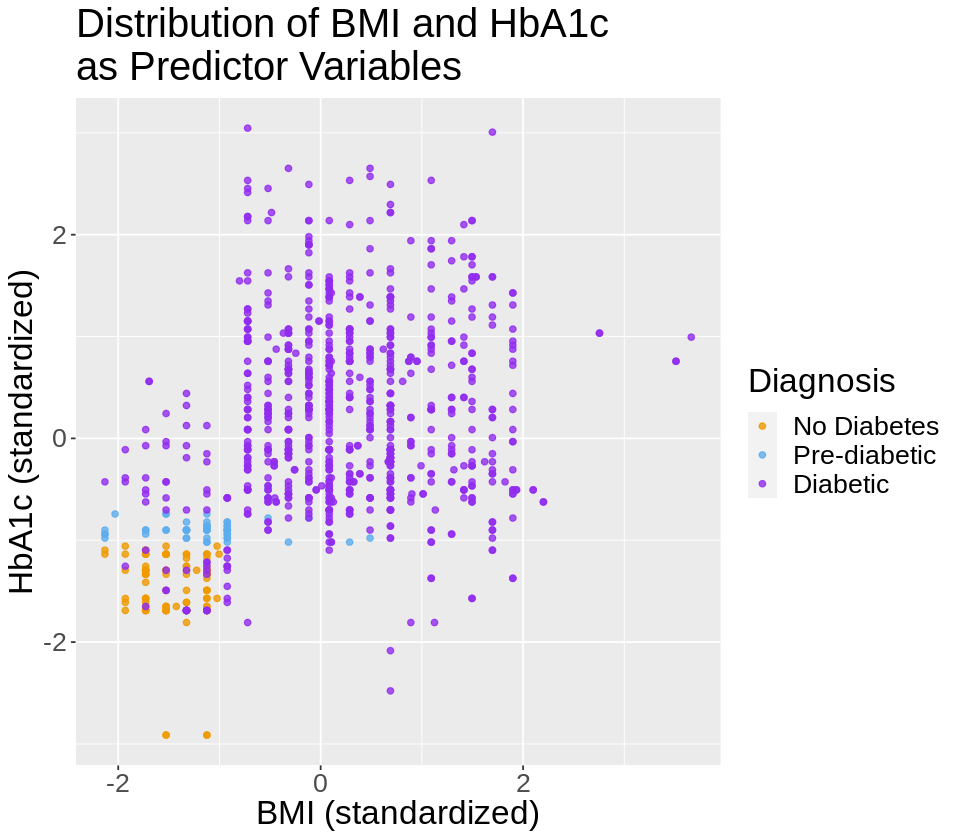

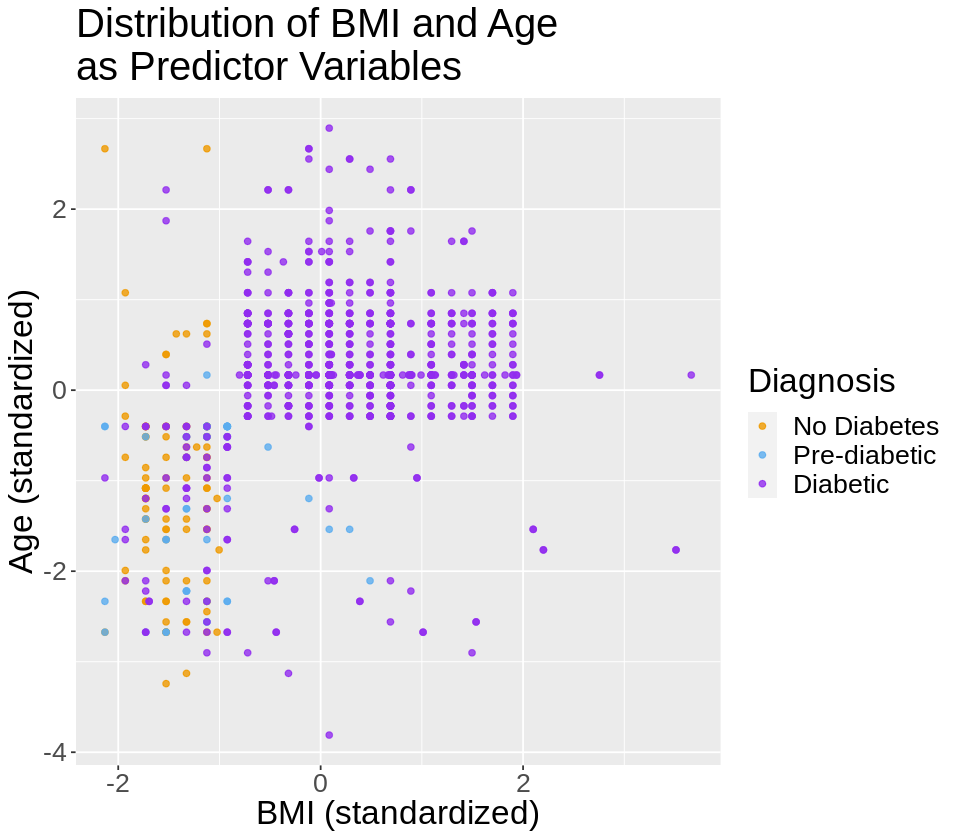

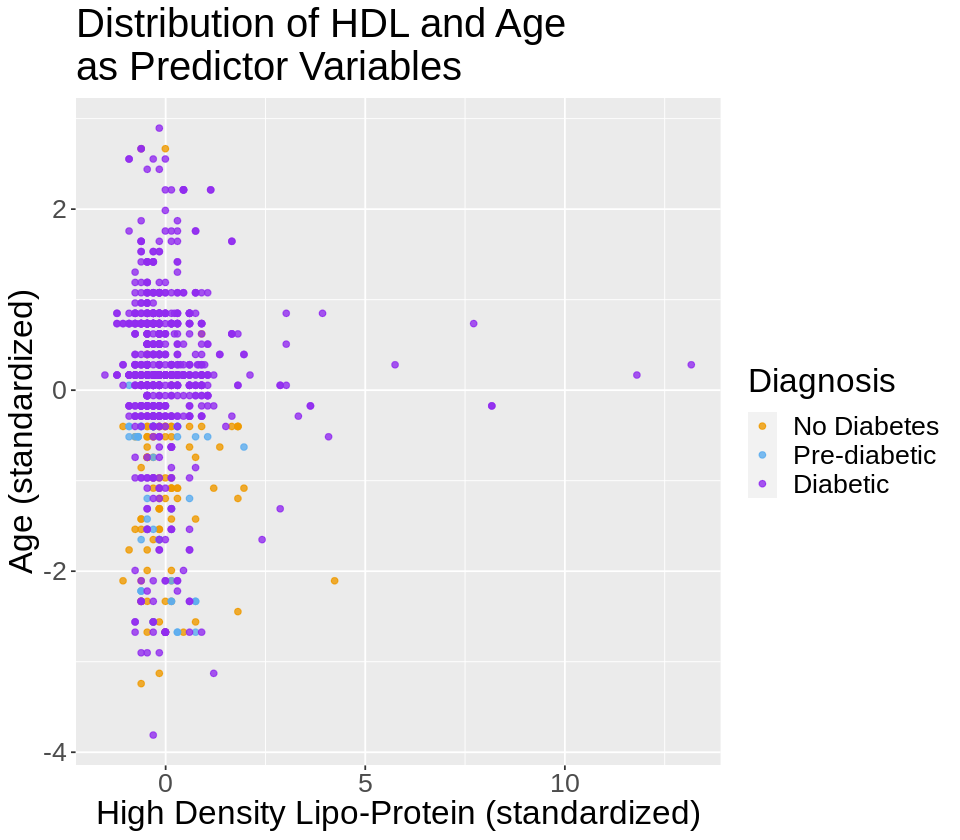

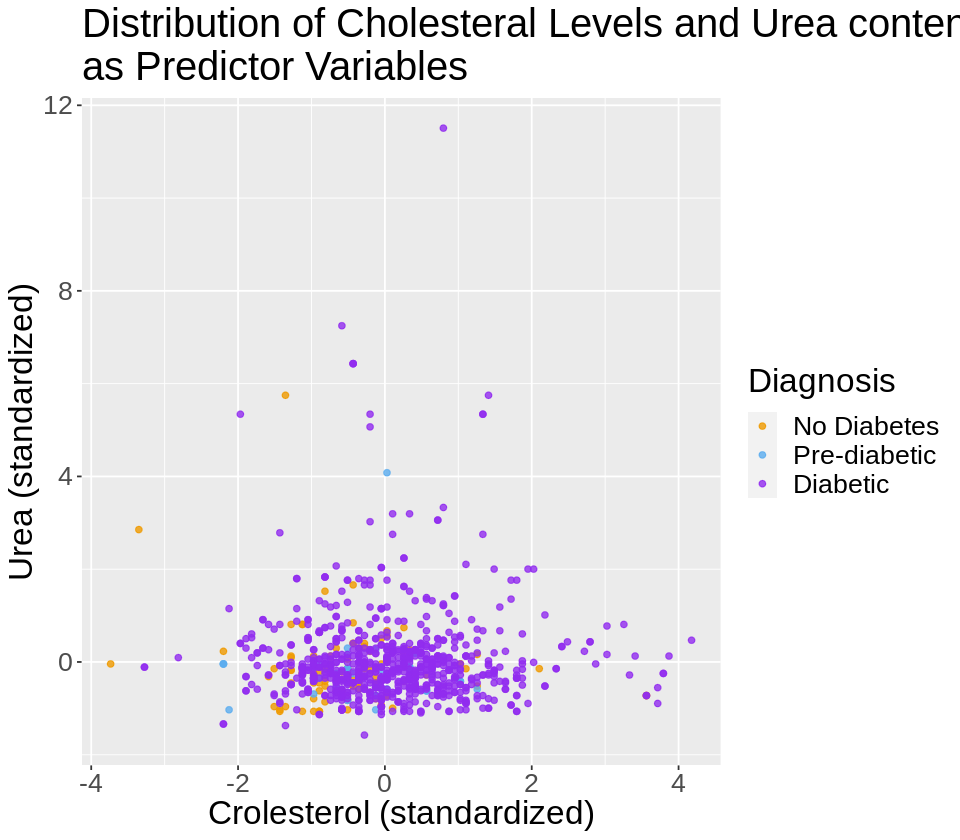

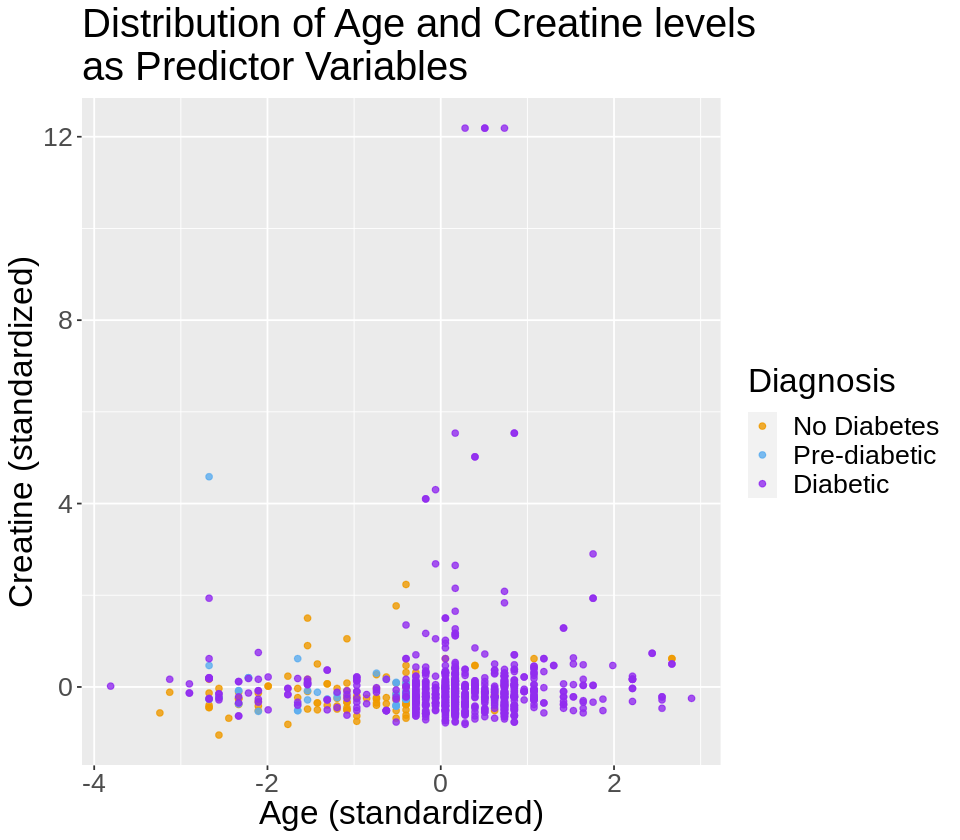

In [37]:
# Initial Graphs of different correlations----
options(repr.plot.width = 8, repr.plot.height = 7)

graph1 <- scaled_diabetes |>
    ggplot(aes(x = BMI, y = HbA1c, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "BMI (standardized)", y = "HbA1c (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of BMI and HbA1c \nas Predictor Variables')

graph2 <- scaled_diabetes |>
    ggplot(aes(x = BMI, y = AGE, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "BMI (standardized)", y = "Age (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of BMI and Age \nas Predictor Variables')

graph3 <- scaled_diabetes |>
    ggplot(aes(x = HDL, y = AGE, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "High Density Lipo-Protein (standardized)", y = "Age (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of HDL and Age \nas Predictor Variables')

graph4 <- scaled_diabetes |>
    ggplot(aes(x = Chol, y = Urea, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "Crolesterol (standardized)", y = "Urea (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of Cholesteral Levels and Urea content \nas Predictor Variables')

graph5 <- scaled_diabetes |>
    ggplot(aes(x = AGE, y = Cr, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "Age (standardized)", y = "Creatine (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of Age and Creatine levels \nas Predictor Variables')

graph1
graph2
graph3
graph4
graph5

### **Methods:**

In the diabetes dataset, we will be using the columns, HBa1c and BMI for the analysis. We chose BMI as it is a standardized method to indicate an individuals health, in addition, the HBa1c was chosen as it shows an individuals average blood sugar over the last three months. Both of these serve as good indicators to predict if an individual is at risk for diabetes, pre-diabetic or diabetic. Based on the plots above, HBa1c and BMI have the most clear distribution in the plot and may provide the best classifier for the required analysis. 

One way of visualizing the results is by using different colors to represent three classifiers: diabetic, non-diabetic and pre-diabetic in a scatter plot. If the prediction matches the actual result, we’ll use one color to represent the points and if the prediction is false, another color will be used. To show how accurate our classifier is, we will compute its accuracy of prediction and construct a confusion matrix for our classifier which shows a table of predicted labels and correct labels.

### **Expected outcomes and significance:**

**What do you expect to find?**

It is expected that a model to predict diabetes based on diagnostic measurements such as blood glucose levels and BMI will be made. We expect the model to predict whether a patient has diabetes with sufficient accuracy. Additionally, it is expected that both BMI and HbA1c will have a poitive correlation with diabetes. 

**What impact could such findings have?**

This model could help individuals at home predict their risk for diabetes and poteintially take corrective measures. For example, if the model predicts that an individual has diabetes, then that individual would be be able to consult their doctor to properly diagnose and treat the disease.

**What future questions could this lead to?**

Developing this model to predict diabetes, may lead to further classifications to predict type 1 vs type 2 diabetes. Additionally, the model may allow us to further understand how the classifiers BMI and HbA1c relate to diabetes.

**Summary of results**

Developing this model to predict diabetes, may lead to further classifications to predict type 1 vs type 2 diabetes. Additionally, the model may allow us to further understand how the classifiers BMI and HbA1c relate to diabetes. The model we generated shows that high BMI and high HbA1c is correlated with individuals with diabetes.

In order to evaluate our classifier's accuracy on unseen data, we need to split our dataset into training and testing sets using the initial_split function. To ensure that the split is done randomly but is also reproducible, we set a random seed value with the set.seed function. We specified prop to be 0.75 so that 75% of our original data ends up in the training set and 25% of our original data ends up in the testing set. We set the strata argument to the categorical label variable, CLASS, to ensure that the training and testing subsets contain the right proportions of each category of observation. We then used the training and testing functions to extract the training and testing datasets into two separate dataframes.

In [38]:
#### Setting the seed
set.seed(1035)

# Creating training and testing splits
diabetes_split <- initial_split(scaled_diabetes, prop = 0.75, strata = CLASS)  
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)
glimpse(diabetes_train)
glimpse(diabetes_test)

Rows: 749
Columns: 11
$ AGE   <dbl> -0.4009437, -0.4009437, -0.4009437, -2.3329285, -0.4009437, -2.4…
$ Urea  <dbl> -0.14470837, -0.14470837, -0.14470837, 0.67296275, -1.06458837, …
$ Cr    <dbl> -0.38248056, -0.38248056, -0.38248056, -0.38248056, -0.31579695,…
$ HbA1c <dbl> -1.334316, -1.334316, -1.334316, -1.334316, -1.689485, -1.689485…
$ Chol  <dbl> -0.50918099, -0.50918099, -0.50918099, 0.02856183, -0.97010341, …
$ TG    <dbl> -1.0345667, -1.0345667, -1.0345667, -0.9631980, -0.7490922, -0.2…
$ HDL   <dbl> 1.809850757, 1.809850757, 1.809850757, -0.612873536, -0.46145326…
$ LDL   <dbl> -1.08491445, -1.08491445, -1.08491445, -0.54684696, -0.45716904,…
$ VLDL  <dbl> -0.3697730, -0.3697730, -0.3697730, -0.3970685, -0.3424774, -0.2…
$ BMI   <dbl> -1.124060, -1.124060, -1.124060, -1.728607, -1.124060, -1.124060…
$ CLASS <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…
Rows: 251
Columns: 11
$ AGE   <dbl> -3.1284516, -0.9691745, -0.6282360, -1.1964668, -2.5602208, -2

To make sure that our class proportions were roughly preserved when the data was split, we used the group_by, summarize, and n functions to find the number and percentage of observations in each CLASS like we did earlier. We can see that about 84.6% of the training data are diabetic observations, 5.3% are pre-diabetic observations, and 10.0% are non-diabetic observations which tells us the class proportions were successfully preserved.

In [39]:
# Making sure that our class proportions were roughly preserved when we split the data
diabetes_proportions <- diabetes_train |>
                            group_by(CLASS) |>
                            summarize(n = n()) |>
                            mutate(percent = 100*n/nrow(diabetes_train))

diabetes_proportions

CLASS,n,percent
<fct>,<int>,<dbl>
N,75,10.013351
P,40,5.340454
Y,634,84.646195


We created a new recipe with only our chosen variables, BMI and HbA1c, as the predictor variables.

In [40]:
# Creating recipe with our chosen predictor variables
diabetes_recipe <- recipe(CLASS ~ BMI + HbA1c, data = diabetes_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

To choose the best value of K for our classifier model, we use cross-validation to calculate an accuracy for each value of K in a reasonable range (1-20) and then pick the value of K that gives us the best accuracy. To do this, we created a model specification and specified that the neighbors argument is going to be tuned using tune(). We then created the k_vals dataframe with a neighbors variable containing values from 1 to 20 (stepping by 1) using the seq function. To perform a 10-fold cross-validation, we use the vfold_cv function with v = 10 to specify that we want to split the diabetes_train dataset into 10 folds. We specify the strata argument to CLASS to ensure that the training and validation subsets contain the right proportions of each category of observation.

Next, we created our data analysis workflow with the tune_grid function instead of the fit or fit_resamples functions to fit the model for each value of K. We specified diabetes_recipe which we created earlier as our recipe and knn_tune as our model specification for the workflow. We pass the 10-fold cross-validation model we created before to the resamples argument and the k_vals dataframe to the grid argument of the tune_grid function. We then use the collect_metrics function to aggregate the mean and standard error of the classifier's validation accuracy across the folds.

In [43]:
# Choosing an appropriate value for K
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

diabetes_vfold <- vfold_cv(diabetes_train, v = 10, strata = CLASS)

knn_results <- workflow() |>
                add_recipe(diabetes_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
                collect_metrics()

We plotted the accuracy of the classifier model against the K value to find the K value that will generate the highest accuracy. It was found that K = 12 is the best. However, the relative accuracy between all of the K values from 1 to 20 was similar with all of them being quite high.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9571318,10,0.007970056,Preprocessor1_Model01
2,accuracy,multiclass,0.9571318,10,0.007970056,Preprocessor1_Model02
3,accuracy,multiclass,0.9571679,10,0.006318970,Preprocessor1_Model03
4,accuracy,multiclass,0.9505002,10,0.005369812,Preprocessor1_Model04
5,accuracy,multiclass,0.9492195,10,0.007113248,Preprocessor1_Model05
6,accuracy,multiclass,0.9505709,10,0.007172265,Preprocessor1_Model06
7,accuracy,multiclass,0.9531494,10,0.006122881,Preprocessor1_Model07
8,accuracy,multiclass,0.9491489,10,0.005640737,Preprocessor1_Model08
9,accuracy,multiclass,0.9545007,10,0.006386642,Preprocessor1_Model09


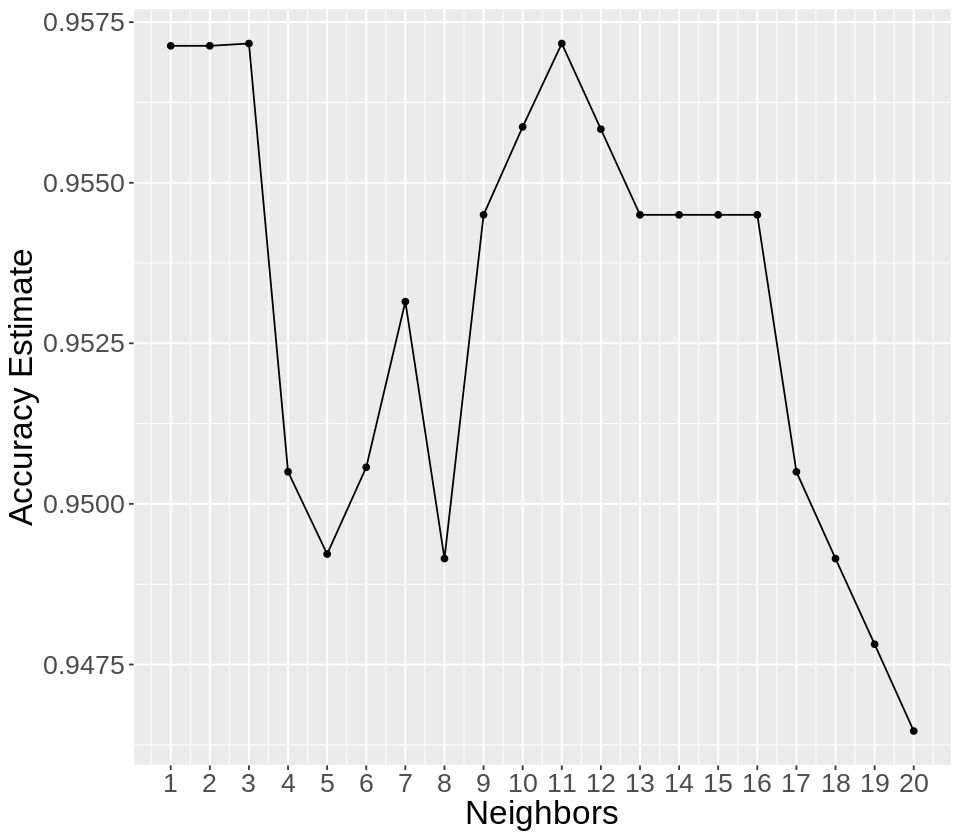

In [44]:
# Finding the accuracy for each value of k from 1 to 20
accuracies <- knn_results |> 
                filter(.metric == "accuracy")
accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                    theme(text = element_text(size = 20))
accuracy_vs_k

We created a new model specification using the value of K =12 as it was found to generate the highest accuracy for our particular classifier model.

In [45]:
# Creating the best specification for our knn classifier model using k = 12
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
                    set_engine("kknn") |>
                    set_mode("classification")

We created a new data analysis workflow with the same recipe (diabetes_recipe) that we created earlier, but this time using the new model specification that we created with K = 12. We then fitted the workflow to the diabetes_train dataset to train our classifier model.

In [46]:
# Creating the workflow for our knn classifier model
diabetes_best_fit <- workflow() |>
                add_recipe(diabetes_recipe) |>
                add_model(knn_best_spec) |>
                fit(data = diabetes_train)

We then passed the new data analysis workflow to the predict function to allow our classifier to predict the CLASS of the observations in the diabetes_test dataset. We then binded the predictions that our classifier made to the diabetes_test dataset itself and stored it as a new variable called diabetes_predictions.

In [47]:
# Fitting our classifier model to the test data
diabetes_test_predictions <- predict(diabetes_best_fit, diabetes_test) |> 
                                bind_cols(diabetes_test)
glimpse(diabetes_test_predictions)

Rows: 251
Columns: 12
$ .pred_class <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…
$ AGE         <dbl> -3.1284516, -0.9691745, -0.6282360, -1.1964668, -2.5602208…
$ Urea        <dbl> -0.21284763, -0.96237948, -0.14470837, -0.86017059, -0.246…
$ Cr          <dbl> -0.1157460905, -0.7492404644, -0.3658096591, -0.0323915676…
$ HbA1c       <dbl> -1.334316, -1.689485, -1.689485, -1.689485, -1.610558, -1.…
$ Chol        <dbl> -0.89328300, -1.50784622, -1.50784622, -0.81646260, -0.970…
$ TG          <dbl> -0.6777236, -0.9631980, -1.1059353, -1.0345667, -1.1773039…
$ HDL         <dbl> -0.158612731, -0.310032999, -0.461453268, 1.809850757, 0.7…
$ LDL         <dbl> -0.457169044, -0.995236535, -0.905558620, 0.977677600, -0.…
$ VLDL        <dbl> -0.3424774, -0.3970685, -0.3970685, -0.2332952, -0.4243641…
$ BMI         <dbl> -1.325575, -1.728607, -1.124060, -1.728607, -1.325575, -1.…
$ CLASS       <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…


To assess the accuracy of our classifier model, we use the metrics function to get the statistics about the quality of our model, specifying the truth argument as CLASS and the estimate argument as .pred_class. We filtered the dataframe to include only the accuracy row since the accuracy metric is the only one we are interested in. An accuracy of 95% is observed which means that our model is well designed and relatively accurate.

In [48]:
# Showing the accuracy of the predictions that our classifier model made on the test data
diabetes_accuracy <- diabetes_test_predictions |>
                        metrics(truth = CLASS, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")
diabetes_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9521912


We also generated a confusion matrix, a table of predicted labels and correct labels, of the predictions that our classifier made on the testing set using the conf_mat function. The confusion matrix shows 200 observations were correctly predicted as diabetic, 12 were correctly predicted as pre-diabetic, and 27 were correctly predicted as non-diabetic. Therefore the classifier labeled 200 + 12 + 27 = 239 observations correctly. It also shows that the classifier made some mistakes; in particular, it classified 9 observations as non-diabetic when they were truly diabetic, 1 observation as non-diabetic when it was truly pre-diabetic, 1 observation as pre-diabetic when it was truly diabetic, and 1 observation as diabetic when it was truly non-diabetic.


In [49]:
# Showing the confusion matrix of the predictions that our classifier made on the test data
diabetes_confusion_matrix <- diabetes_test_predictions |> 
                                conf_mat(truth = CLASS, estimate = .pred_class)
diabetes_confusion_matrix

          Truth
Prediction   N   P   Y
         N  27   1   9
         P   0  12   1
         Y   1   0 200

To visualize the distibution of the predicted model, a kernel graph was made versus the training dataset. The model shows that regions of the plot where the classifiers are confined.

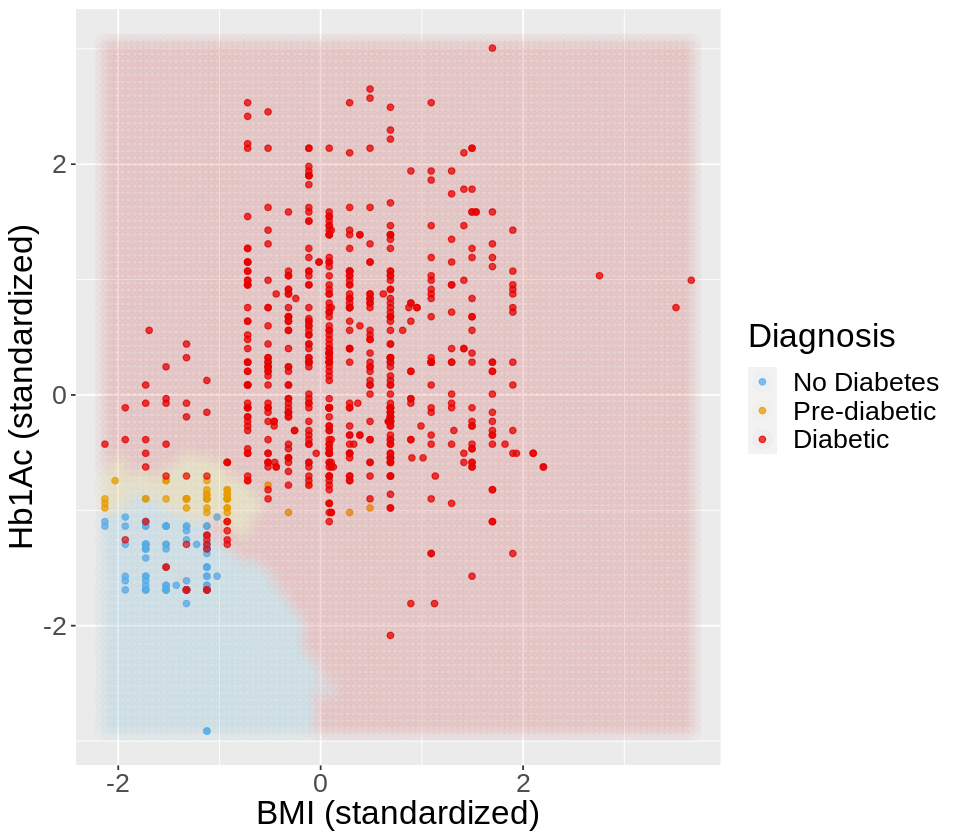

In [50]:
# Scatter plot of Hb1Ac concentration versus BMI concentration where background color indicates the decision of the classifier
bmi_grid <- seq(min(scaled_diabetes$BMI), 
                max(scaled_diabetes$BMI), 
                length.out = 100)
HbA1c_grid <- seq(min(scaled_diabetes$HbA1c),
                  max(scaled_diabetes$HbA1c),
                  length.out = 100)
asgrid <- as_tibble(expand.grid(BMI = bmi_grid, 
                                HbA1c = HbA1c_grid))


# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(diabetes_best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
                        rename(Class = .pred_class)

wkflw_plot <- ggplot() +
                geom_point(data = diabetes_train, mapping = aes(x = BMI, y = HbA1c, color = CLASS), alpha = 0.75) +
                geom_point(data = prediction_table, mapping = aes(x = BMI, y = HbA1c, color = Class), alpha = 0.02, size = 5) +
                labs(color = "Diagnosis", x = "BMI (standardized)", y = "Hb1Ac (standardized)") +
                scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("steelblue2", "orange2", "red2")) +
                theme(text = element_text(size = 20))
wkflw_plot